In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import backend as K

rate=pd.read_csv('data/USD_KRW.csv')
rate.columns=['date', 'rate']
rate=rate.set_index('date')

kolib=pd.read_csv('data/KORIBOR.csv')
kolib=kolib[['date', '6month']]
kolib.columns=['date','krlibor']
kolib=kolib.set_index('date')


uslib=pd.read_csv('data/libor.csv')
uslib.columns=['date','uslibor']
uslib=uslib.set_index('date')

del uslib['uslibor']['2018-12-25']
del uslib['uslibor']['2019-01-01']
del uslib['uslibor']['2019-05-27']
del uslib['uslibor']['2019-12-25']
del uslib['uslibor']['2020-01-01']

uslib['uslibor'].loc['2018-03-30'] = (float(uslib['uslibor'].loc['2018-03-29']) * 2/3 
                                            + float(uslib['uslibor'].loc['2018-04-03']) * 1/3)

uslib['uslibor'].loc['2018-04-02'] = (float(uslib['uslibor'].loc['2018-03-29']) * 1/3 
                                            + float(uslib['uslibor'].loc['2018-04-03']) * 2/3)

uslib['uslibor'].loc['2018-05-07'] = (float(uslib['uslibor'].loc['2018-05-04']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-05-08']) * 1/2)

uslib['uslibor'].loc['2018-05-28'] = (float(uslib['uslibor'].loc['2018-05-25']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-05-29']) * 1/2)

uslib['uslibor'].loc['2018-08-27'] = (float(uslib['uslibor'].loc['2018-08-24']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-08-28']) * 1/2)

uslib['uslibor'].loc['2018-12-26'] = (float(uslib['uslibor'].loc['2018-12-24']) * 2/3 
                                            + float(uslib['uslibor'].loc['2018-12-27']) * 1/3)

uslib['uslibor'].loc['2019-04-19'] = (float(uslib['uslibor'].loc['2019-04-23']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-04-18']) * 1/3)

uslib['uslibor'].loc['2019-04-22'] = (float(uslib['uslibor'].loc['2019-04-18']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-04-23']) * 1/3)

uslib['uslibor'].loc['2019-05-06'] = (float(uslib['uslibor'].loc['2019-05-03']) * 1/2
                                            + float(uslib['uslibor'].loc['2019-05-07']) * 1/2)

uslib['uslibor'].loc['2019-08-26'] = (float(uslib['uslibor'].loc['2019-08-23']) * 1/2
                                            + float(uslib['uslibor'].loc['2019-08-27']) * 1/2)

uslib['uslibor'].loc['2019-12-26'] = (float(uslib['uslibor'].loc['2019-12-24']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-12-27']) * 1/3)

uslib['uslibor']=uslib['uslibor'].apply(pd.to_numeric)



snp500=pd.read_csv('data/S&P500.csv')
snp500 = snp500[::-1]
snp500=snp500[['날짜','종가']]
snp500.columns=['date','snp500']


snp500_date=[]
for i in snp500['date']:
    snp500_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

snp500_price=[]
for i in snp500['snp500']:
    i=i.replace(',','')
    snp500_price.append(np.float(i))

snp500['date']=snp500_date
snp500['snp500']=snp500_price
snp500=snp500.set_index('date')

kospi200=pd.read_csv('data/KOSPI200.csv')
kospi200=kospi200[['날짜','종가']]
kospi200.columns=['date','kospi200']
kospi200 = kospi200[::-1]

kospi_date=[]
for i in kospi200['date']:
    kospi_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

kospi200['date']=kospi_date
kospi200=kospi200.set_index('date')

data=pd.concat([rate,kolib,uslib,snp500,kospi200], axis=1,  join = 'inner', sort=False)

Using TensorFlow backend.


In [2]:
test = pd.concat([rate,kolib,uslib,snp500,kospi200], axis=1,  join = 'inner', sort=False)
test = test.loc['2019-09-01':'2019-12-31']
test = test[['rate']]

In [3]:
data=data[['krlibor','uslibor','snp500','kospi200','rate']]

In [4]:
mean = data[:'2019-06-31'].mean(axis=0)
data -= mean
std = data[:'2019-06-31'].std(axis=0)
data /= std

In [5]:
#train 크기
train_size = len(data.loc[:'2019-06-31'])
#train ~ valid 크기
valid_size = len(data.loc[:'2019-08-31'])

In [6]:
data = np.array(data)

## 제네레이터 함수 설정

- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
- shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [7]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1] #target설정
        yield samples, targets

In [8]:
lookback = 5
step = 1
delay = 1
batch_size = 32

In [9]:
train_gen = generator(data, lookback = lookback, delay = delay, min_index = 0, max_index = train_size, 
                    shuffle = True , step = step, batch_size = batch_size)
val_gen = generator(data, lookback = lookback, delay = delay, min_index = train_size+1,
                    shuffle = True, max_index = valid_size, step = step, batch_size = batch_size)

test_gen = generator(data, lookback = lookback, delay = delay, min_index = valid_size+1,
                     shuffle = False, max_index = None, step = step, batch_size = batch_size)

In [10]:
val_steps = (valid_size - (train_size+1) - lookback) // batch_size

test_steps = (len(data) - (valid_size+1) - lookback) // batch_size

### 양방향 제네레이터 설정

In [11]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets
        
train_gen_reverse = reverse_order_generator(data, lookback=lookback, delay=delay, min_index=0,
                                            max_index=train_size, shuffle=True, step=step, batch_size=batch_size)
val_gen_reverse = reverse_order_generator(data, lookback=lookback, delay=delay, min_index=train_size+1,
                                          shuffle = True, max_index=valid_size,step=step, batch_size=batch_size)

## 기본적인 머신 러닝 방법

In [12]:
model1 = Sequential()
model1.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1))

model1.compile(optimizer=RMSprop(), loss='mae')

model1.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1711 - val_loss: 0.2477
Epoch 2/20
500/500 [==============================] - 2s 3ms/step - loss: 0.1119 - val_loss: 0.2919
Epoch 3/20
500/500 [==============================] - 2s 4ms/step - loss: 0.1019 - val_loss: 0.2271
Epoch 4/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0949 - val_loss: 0.2816
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0897 - val_loss: 0.3912
Epoch 6/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0869 - val_loss: 0.5228
Epoch 7/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0837 - val_loss: 0.3534
Epoch 8/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0817 - val_loss: 0.2468
Epoch 9/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0805 - val_loss: 0.5246
Epoch 10/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0794 - val_loss: 0.7476

In [13]:
pred1=pd.DataFrame(model1.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
pred1=pred1[:len(test.index)]
pred1=pred1.set_index(test.index)
pred1.columns = ['model1']

## 첫 번째 순환 신경망

In [14]:
model2 = Sequential()
model2.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')

model2.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1577 - val_loss: 1.1656
Epoch 2/20
500/500 [==============================] - 6s 11ms/step - loss: 0.1152 - val_loss: 0.9483
Epoch 3/20
500/500 [==============================] - 5s 11ms/step - loss: 0.1067 - val_loss: 0.9148
Epoch 4/20
500/500 [==============================] - 5s 11ms/step - loss: 0.1015 - val_loss: 0.8306
Epoch 5/20
500/500 [==============================] - 5s 11ms/step - loss: 0.0974 - val_loss: 1.0075
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0903 - val_loss: 0.9754
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.0854 - val_loss: 0.8547
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0792 - val_loss: 0.8719
Epoch 9/20
500/500 [==============================] - 6s 11ms/step - loss: 0.0779 - val_loss: 0.9226
Epoch 10/20
500/500 [==============================] - 6s 11ms/step - loss: 0.0747 - val_lo

In [15]:
pred2=pd.DataFrame(model2.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
pred2=pred2[:len(test.index)]
pred2=pred2.set_index(test.index)
pred2.columns = ['model2']

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

In [16]:
model3 = Sequential()

model3.add(layers.GRU(32, dropout=0.2,recurrent_dropout=0.2,input_shape=(None, data.shape[-1])))
model3.add(layers.Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')
model3.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 6s 12ms/step - loss: 0.2505 - val_loss: 0.9580
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.2135 - val_loss: 0.8052
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1883 - val_loss: 0.6988
Epoch 4/40
500/500 [==============================] - 6s 11ms/step - loss: 0.1761 - val_loss: 0.7095
Epoch 5/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1703 - val_loss: 0.8050
Epoch 6/40
500/500 [==============================] - 6s 11ms/step - loss: 0.1643 - val_loss: 0.8046
Epoch 7/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1587 - val_loss: 0.7717
Epoch 8/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1530 - val_loss: 0.6910
Epoch 9/40
500/500 [==============================] - 6s 11ms/step - loss: 0.1509 - val_loss: 0.8345
Epoch 10/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1465 - val_lo

In [17]:
pred3=pd.DataFrame(model3.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
pred3=pred3[:len(test.index)]
pred3=pred3.set_index(test.index)
pred3.columns = ['model3']

## 스태킹 순환 층

In [18]:
model4 = Sequential()

model4.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, data.shape[-1])))
model4.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model4.add(layers.Dense(1))

model4.compile(optimizer=RMSprop(), loss='mae')
model4.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 11s 23ms/step - loss: 0.2604 - val_loss: 1.4914
Epoch 2/40
500/500 [==============================] - 10s 20ms/step - loss: 0.2088 - val_loss: 0.9661
Epoch 3/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1872 - val_loss: 0.5245
Epoch 4/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1724 - val_loss: 0.5644
Epoch 5/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1624 - val_loss: 0.3779
Epoch 6/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1546 - val_loss: 0.5491
Epoch 7/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1512 - val_loss: 0.4733
Epoch 8/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1463 - val_loss: 0.4148
Epoch 9/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1398 - val_loss: 0.7093
Epoch 10/40
500/500 [==============================] - 10s 20ms/step - loss: 0.136

KeyboardInterrupt: 

In [19]:
pred4=pd.DataFrame(model4.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
pred4=pred4[:len(test.index)]
pred4=pred4.set_index(test.index)
pred4.columns = ['model4']

## 양방향 RNN 사용하기

In [20]:
model5 = Sequential()
model5.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model5.add(layers.Dense(1))
model5.compile(optimizer=RMSprop(), loss='mae')
model5.fit_generator(train_gen_reverse, steps_per_epoch=500, epochs=20, validation_data=val_gen_reverse,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1550 - val_loss: 0.9275
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1148 - val_loss: 1.1901
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1056 - val_loss: 0.9475
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1002 - val_loss: 1.0144
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0936 - val_loss: 1.1134
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0887 - val_loss: 0.9763
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0843 - val_loss: 0.8485
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0803 - val_loss: 0.8709
Epoch 9/20
500/500 [==============================] - 5s 9ms/step - loss: 0.0766 - val_loss: 0.9078
Epoch 10/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0744 - val_los

In [21]:
pred5=pd.DataFrame(model5.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
pred5=pred5[:len(test.index)]
pred5=pred5.set_index(test.index)
pred5.columns = ['model5']

## 양방향 RNN

In [ ]:
# model6 = Sequential()
# model6.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, data.shape[-1])))
# model6.add(layers.Dense(1))

# model6.compile(optimizer=RMSprop(), loss='mae')
# model6.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
# pred6=pd.DataFrame(model6.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
# pred6=pred6[:len(test.index)]
# pred6=pred6.set_index(test.index)
# pred6.columns = ['model6']

#### 최종 dataframe 만들기

In [22]:
pred_df = pd.concat([pred1, pred2, pred3, pred4, pred5],axis=1)
pred_df.columns = ['model1','model2','model3','model4','model5']
pred_df.head()

,model1,model2,model3,model4,model5
date,,,,,
2019-09-03,1165.133545,1155.648926,1151.181519,1158.374878,1144.427246
2019-09-04,1160.491821,1151.798218,1147.690552,1156.518799,1141.972290
2019-09-05,1162.735596,1150.618530,1147.871338,1157.894653,1143.834106
2019-09-06,1158.064209,1147.594727,1145.832275,1154.756958,1142.048340
2019-09-09,1160.765015,1146.602051,1146.469727,1156.739990,1142.193481


In [ ]:
# pred_df = pd.concat([pred1, pred2, pred3, pred4, pred5, pred6],axis=1)
# pred_df.columns = ['model1','model2','model3','model4','model5','model6']
# pred_df.head()

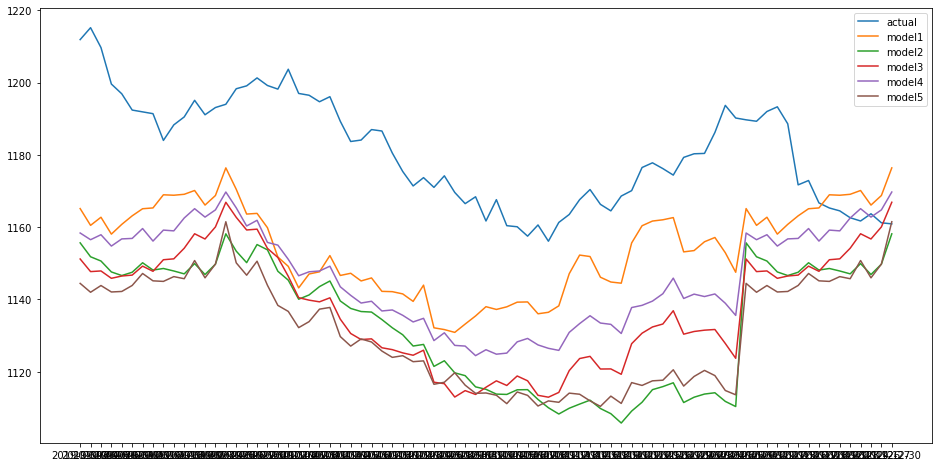

In [23]:
plt.figure(figsize=(16,8))
plt.plot(test, label='actual')
plt.plot(pred_df['model1'],label='model1')
plt.plot(pred_df['model2'],label='model2')
plt.plot(pred_df['model3'],label='model3')
plt.plot(pred_df['model4'],label='model4')
plt.plot(pred_df['model5'],label='model5')
#plt.plot(pred_df['model6'],label='model6')
plt.legend()

plt.show()

In [26]:
from sklearn.metrics import mean_squared_error
for i in pred_df.columns:
    RMSE = mean_squared_error(test, pred_df[i])**0.5    
    print("RMSE",i,'번모델 :',RMSE)

RMSE model1 번모델 : 30.642202861059452
RMSE model2 번모델 : 49.367232621167126
RMSE model3 번모델 : 45.706315525695054
RMSE model4 번모델 : 37.1276356021913
RMSE model5 번모델 : 51.62647393037229


해볼것
- 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
- RMSprop 옵티마이저가 사용한 학습률을 조정합니다.
- GRU 대신 LSTM 층을 사용합니다.
- 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다.
- 최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.